In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import sklearn as sklearn
from sklearn import decomposition,cluster
import plotly.graph_objects as go
import re
import statsmodels.api as sm
import geoplot as gplt
import geopandas as gpd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

#Fonction pour trouver les codes correspondants à un pays entre les codes de pays et le nom des pays :"
def refresh_dico(Name,Code,df):
    dic = {}
    for i in df[[Name,Code]].dropna().drop_duplicates().iterrows() :
        dic[i[1][Name]] = i[1][Code]
    return (dic)
    

#fonction pour trouver toutes les lignes qui correspondent à un pays où à une variable en particulier

def rech_ligne_pays (y,df) :
    expression = re.compile(dic_pays[y]+".*?;")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def rech_ligne_indic (y,df):
    expression = re.compile(".{,4}"+y+";")
    return(list(i[:-1] for i in (expression.findall(';'.join(df.index)+';'))))

def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

def regress (regresseur,regresse) :
    x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc[regresseur].to_numpy())
    y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc[regresse].to_numpy()

    model = sm.OLS(y,x,'drop')
    results = model.fit()
    return(results)
#/!\ il faut entre le nom avec des caractères regex pour les ( et %)
        

On construit un dictionnaire nom du pays / code du pays :

# On va télécharger les bases de données et repérer les variables pertinentes dans chacune des bases

### On commmence par créer les dataframe

Il faut légèrement modifier le fichier csv dézippé pour enlever les deux premières lignes, qui ne comprennent que des infos générales sur le format du fichier mais qui entrainaient un problème d'ouverture via la commande pd.read_csv car elles comportaient des virgules.

On peut ensuite ouvrir sereinement toutes les base modifiées ainsi.

In [90]:
agri_forest = pd.read_csv("chiffre_agri_foret_peche.csv")
augment_pib = pd.read_csv("chiffre_augment_pib.csv")
energie_utilisee = pd.read_csv("chiffre_energie_utilise.csv")
emission_GES = pd.read_csv("chiffre_GES_total.csv")
nucle_total = pd.read_csv('chiffre_nucle_total_nuke_total_fossile.csv')
part_indus_construc = pd.read_csv('chiffre_part_indus_construc.csv')
pib = pd.read_csv("chiffre_pib.csv")
pop = pd.read_csv('chiffre_population.csv')
nom_pays = pib['Country Name']


In [91]:
df_list  = [agri_forest, augment_pib, energie_utilisee, emission_GES, nucle_total, part_indus_construc, pib,pop]

### On regarde chaque dataframe pour identifier les variables pertinentes

Ici on cherche à identifier certaines variables qui pourront se révéler pertinentes pour l'analyse, et on les stocke dans un dictionnaire afin que celles-ci soit facilement accessible :

In [92]:
dic = {}
dic['pib'] = '_GDP (current US$)'
dic['pib_hab'] = '_GDP (current US$) par Tete'
dic['pib_growth'] = '_GDP growth (annual %)'
dic['pib_hab_growth'] = '_Croissance_GDP (current US$) par Tete (pourcent)'
dic['pop'] = '_Population, total'
dic['ges'] = '_Émissions totales de GES (kt d’équivalent CO2)'
dic['ges_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) (pourcent)	'
dic['ges_hab'] = '_Émissions totales de GES (kt d’équivalent CO2) par Tete'
dic['ges_hab_growth'] = '_Croissance_Émissions totales de GES (kt d’équivalent CO2) par Tete (pourcent)'
dic['industry'] = '_Industry (including construction), value added (% of GDP)'
dic['agr'] = '_Agriculture, forestry, and fishing, value added (% of GDP)'
dic['clean_nrj'] = '_Alternative and nuclear energy (% of total energy use)'
dic['nrj_hab'] = '_Energy use (kg of oil equivalent per capita)'
dic['nrj_hab_growth'] = '_Croissance_Energy use (kg of oil equivalent per capita) (pourcent)'

### On nettoie les bases en enlevant les informations qui ne nous intéresse pas

Il faudra enlever la colomne "unnamed", les colomnes qui correpondent aux années qui ne nous intéresssent pas, et éventuellement les lignes (=pays ou région) que l'on ne garde pas.

Par exemple, conserve-t-on les pays comme Aruba dont on ne connait que le PIB? Je pense que la question elle est vite répondue.

Pareil, est-ce que ça a vraiement un intérêt de garder les zones géographiques du type Asie du Sud-Est, etc?  ce ne sont que des aggrégats de pays, donc pas forcément.

### On fusionne les dataframe pour aggréger tous ces indicateurs

On peut envisager plusieurs manières de fusionner ces df. Soit on a en index Pays_Année et les colomnes correspindent chacune à un indice, soit on a Pays_Indicateur et les colonnes correspondent chacune a une année. Ce sont les formats wide et long (cf tp2).

Pour des raisons de lisibilité, il est évident que l'on va conserver le nom de l'indicateur, et non pas son nom de code. En revanche, il faudra voir à l'usage si on préfère utiler le nom complet des pays ou seulement leur nom de code

On concatène les df, on les trie et on met en index la variable créée à cet effet ci-dessus.

In [93]:
#On fait ici la modif sur tous les df à l'aide d'une boucle for, 
for df in df_list :
    df['Pays_indic'] = df['Country Code'].str[:3] + '_' + df['Indicator Name'].str[:99]
#part_indus_construc['Pays_indic']

df = pd.concat(df_list)
df = df.sort_values('Pays_indic').set_index('Pays_indic')
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
Pays_indic,,,,,,,,,,,,,,,,,,,,,
"ABW_Agriculture, forestry, and fishing, value added (% of GDP)",Aruba,ABW,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Alternative and nuclear energy (% of total energy use),Aruba,ABW,Alternative and nuclear energy (% of total ene...,EG.USE.COMM.CL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_Energy use (kg of oil equivalent per capita),Aruba,ABW,Energy use (kg of oil equivalent per capita),EG.USE.PCAP.KG.OE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABW_GDP (current US$),Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
ABW_GDP growth (annual %),Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.369863e+00,4.198232e+00,3.000000e-01,5.700001e+00,2.100000e+00,1.999999e+00,NaN,NaN,NaN,NaN


In [94]:
code_list = []
for i in df['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

def gen_croissance(variable):
    for i in code_list:
        df.loc[i+'_Croissance'+variable+' (pourcent)']=100*df.loc[i+variable][4:].astype(np.float64).diff() / (df.loc[i+variable][4:].astype(np.float64)-df.loc[i+variable][4:].astype(np.float64).diff())
        df.loc[i+'_Croissance'+variable+' (pourcent)',['Country Name','Country Code']]=df.loc[i+variable,['Country Name','Country Code']]
        df.loc[i+'_Croissance'+variable+' (pourcent)','Indicator Name']='Croissance '+variable
    return 

def gen_par_tete(variable):
    for i in code_list:
        df.loc[i+variable+' par Tete']= df.loc[i+variable][4:].astype(np.float64) / df.loc[i+'_Population, total'][4:].astype(np.float64)
        df.loc[i+variable+' par Tete',['Country Name','Country Code']]=df.loc[i+variable,['Country Name','Country Code']]
        df.loc[i+variable+' par Tete','Indicator Name']= variable + ' par Tete'
    return

gen_par_tete('_GDP (current US$)')
gen_par_tete('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2)')
gen_croissance('_GDP (current US$) par Tete')
gen_croissance('_Émissions totales de GES (kt d’équivalent CO2) par Tete')
gen_croissance('_Energy use (kg of oil equivalent per capita)')


### Suppression des colonnes et lignes inutiles

On a ici la liste des colonnes que l'on supprimme pour se restreindre aux données qui nous intéressent, sutrement dit à partir de 1980 (je ne sais plsu si on avait dit 1980 ou 1985).

In [95]:
useless_data_list = ['Unnamed: 65', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', 
                   '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '2020']
df = df.drop(useless_data_list, axis = 1)
#df.sample(15)

# Premières représentations graphiques

On créer une fonction afin de récupérer les moyennes des variables qui nous intéressent :

In [96]:
def create_average(var,df) :
    temp_list = ['Average','AVG',var]
    for column in df1.columns[3:]:
        temp_list.append(df1[column].where('_' + df1['Indicator Name'] == var).mean())
    df1.loc['AVG' + var] = temp_list

var_list = ['_GDP (current US$)', '_Émissions totales de GES (kt d’équivalent CO2)', 
           '_Alternative and nuclear energy (% of total energy use)']
for var in var_list : 
    create_average(var,df1)

var_list

['_GDP (current US$)',
 '_Émissions totales de GES (kt d’équivalent CO2)',
 '_Alternative and nuclear energy (% of total energy use)']

In [97]:
def triplot_seaborn (var1,var2,country_code,Titre,var3 = None) :
    year = list(df)[3:]
    for i in range(len(year)):
        year[i] = float(year[i])

    df_plot = df.drop(['Country Name', 'Country Code', 'Indicator Name'], axis = 1)
    df_plot.loc['year'] = year
    df_plot = df_plot.T
    if var3 != None :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            hue = country_code + var3, 
                            size = country_code + var2, 
                            palette = 'rocket_r', 
                            sizes = (30,300), 
                            kind = 'scatter')
    else :
        graph = sns.relplot(data = df_plot,
                            x= 'year', y = country_code + var1,
                            size = country_code + var2, 
                            sizes = (30,300),
                            kind = 'scatter')
    
    graph.set_axis_labels('Date','PIB').set_titles(Titre)
    return(graph)


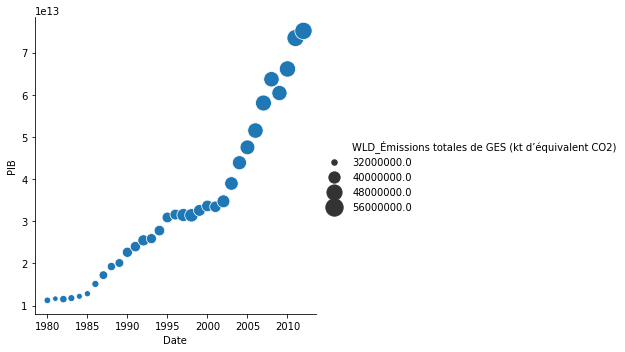

In [98]:
triplot_seaborn('_GDP (current US$)',
                '_Émissions totales de GES (kt d’équivalent CO2)',
                'WLD','PIB mondiale en fonction du temps',
                var3 = None)

Ici on peut voir les le pib mondiale en fonction du temps, coloré par les émissions mondiales de GES. On peut clairement voir que le PIB mondial n'a cessé de croître sur toutes la période, tout comme les émissions de gazs à effet de serre comme on peut le voir au travers du fait que les points sont de plus en plus foncés au fur et à mesure que l'on avance dans le temps 

Ce graphique explicite bien le fait stylisé que l'économie mondiale s'est développé en même temps que les émissions de gazs à effet de serre du à l'activité économique grossissaient, et ce sans presque aucune interruption. En effet, le développement d'industrie lourde dans les pays en développement (comme la métallurgie en Chine par exemple) ou le développement d'agriculture à grande échelle mécanisée (comme au Brésil) a fortement pesé dans le bilan carbone de ces pays, comme on peut le voir dans les graphiques suivant :

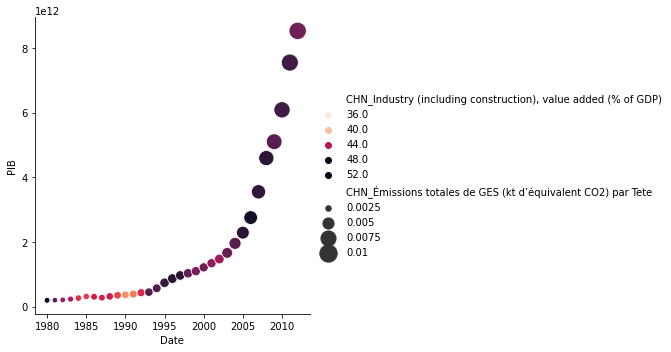

In [99]:
triplot_seaborn('_GDP (current US$)',
                '_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                'CHN',
                'PIB de la Chine en fonction du temps',
                var3 ='_Industry (including construction), value added (% of GDP)' )

Comme on peut le voir ici la chine a fortement développé son industrie a partir des années 1980, ce qui a fait que celle-ci a gardé une aprt constante dans le PIB voir a même pris de l'importance alors même que le PIB de la chine augmentait très fortement chaque année. De plus, on peut observer en parrallèle le développement des émissions de gazs à effet de serre par tête de la Chine. 

Ce graphique nous montre bien un certain sentier de croissance suivi par la Chine, qui laisse une grande place à l'industrie fortement polluante et donc à l'émission de gazs à effet de serre.

Même si le Brésil n'a pas subie une industrialisation aussi lourde que la Chine on peut voir que ses émissions de gazs à effet de serre par habitant

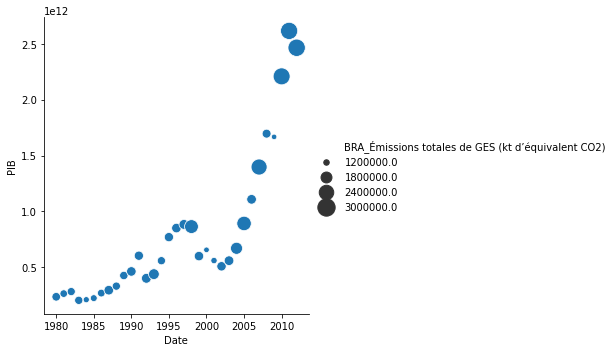

In [100]:
triplot_seaborn('_GDP (current US$)',
                '_Émissions totales de GES (kt d’équivalent CO2)',
                'BRA',
                'PIB du Brésil en fonction du temps')


On peut voir que là aussi le développement du pays a été fortement corréllé au développement des émissions de gazs à effet de serre. Cependant ici cette croissance des émissions est pour le pays globale, et non pas par tete. En effet, si on regarde ce que donne 

In [101]:
#geoplot à utiliser das le cas d'une base avec des années (on a donc année et indic sur les lignes et années en colonnes)

def geo_plot (df,indic,annee,Titre = None,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe: 
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)

    gdf = create_gdf(df.loc[rech_ligne_indic(indic,df),['Country Code',annee]],map_monde)
    
    if norm :
        gdf[annee] = log_norm(gdf[annee])
    
    gplt.choropleth(gdf,
                    hue = annee,
                    cmap = couleur,
                    legend=True,
                    ax=ax)
        
    
    plt.show()
    
#La fonction intermédiaire que l'on utilise pour créer le géodataframe :
def create_gdf (df_geo,map_monde) :
    map_monde_clean = pd.DataFrame()
    map_monde_clean[['Country Code','geometry']] = map_monde[['iso_a3','geometry']].dropna()
    gdf = gpd.GeoDataFrame(df_geo.dropna().reset_index().merge(map_monde_clean,on = 'Country Code'),
                           geometry=df_geo.dropna()
                                       .reset_index()
                                       .merge(map_monde_clean,on = 'Country Code')['geometry'])
    return(gdf)
#La fonction pour passer nos valeurs au logarithme en base 10.
def log_norm (df_norm) :
    return(np.log10(df_norm.astype(np.float64)))
    #/np.log10(df_norm.astype(np.float64).max()))


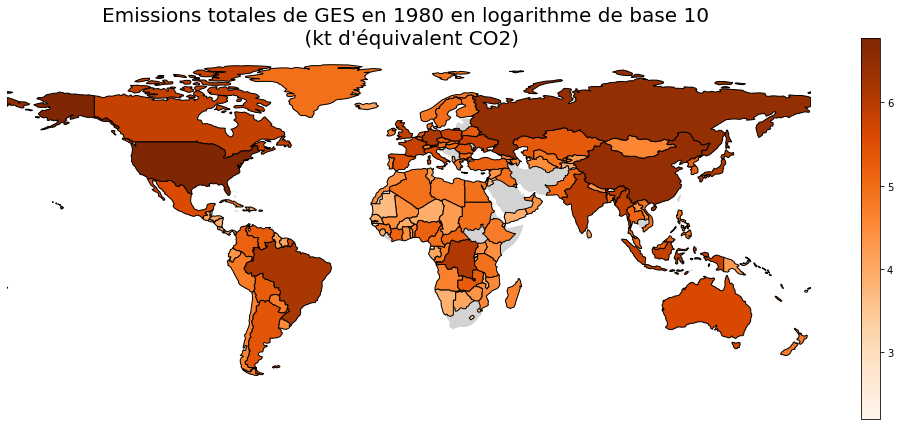

In [102]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\)',
         '1980',
         Titre = 'Emissions totales de GES en 1980 en logarithme de base 10 \n (kt d\'équivalent CO2)',
         couleur = 'Oranges',
         norm=True)

On peut voir ici les émissions totales de gaz à effet de serre sur une map-monde. On peut déjà y voir que le plus gros pollueurs de l'époque sont les Etats-Unis, tallonné par la Russie. On peut aussi remarquer que la Chine fait elle aussi déjà parti des plus gros émetteurs de gazs à effet de serre en 1980, cependant cette projection ne prend pas en compte la population de chaque pays, qui est de fait une variable d'importance pour mesurer les gazs à effet de serre sur l'ensemble du pays. 

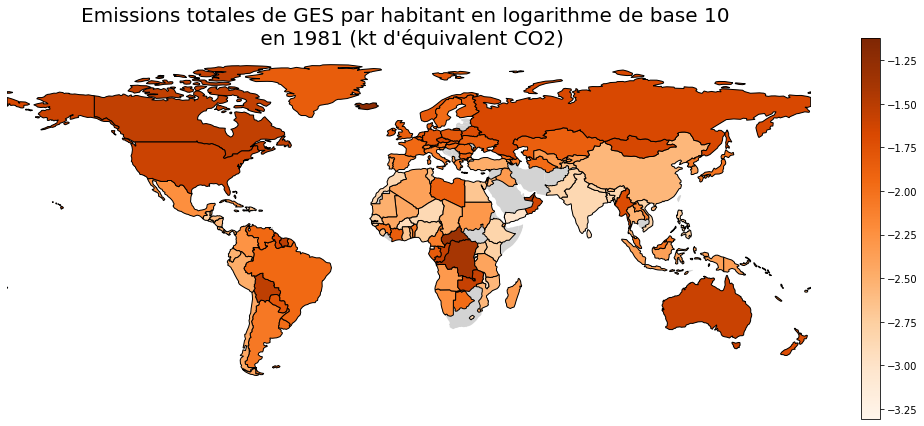

In [103]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\) par Tete',
         '1981',
         Titre = 'Emissions totales de GES par habitant en logarithme de base 10 \n en 1981 (kt d\'équivalent CO2)',
         couleur = 'Oranges',
         norm=True)

On peut donc voir que rapporter par tête,  la Chine et l'Inde ne sont en rélaité en 1980 par de très gros émetteurs, là ou la Russie et les Etats Unis restent dans les plus gros émetteurs de la période, avec l'Europe et l'Australie. Si on compare cette carte à celle dans les années 2000 :

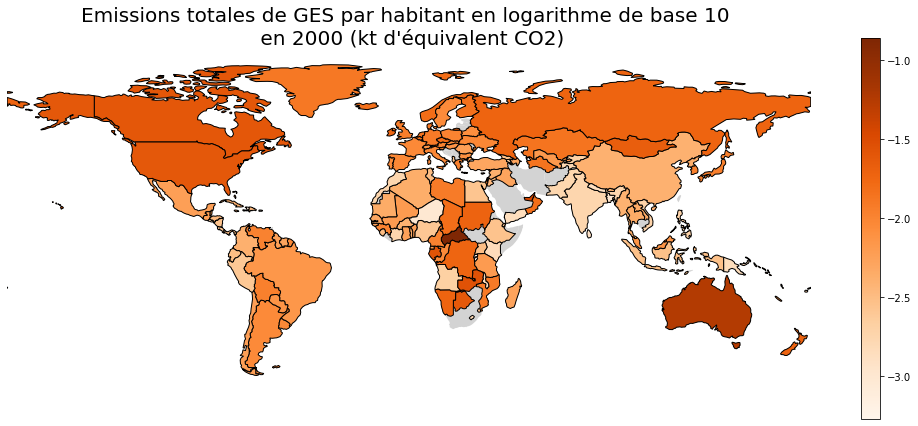

In [104]:
geo_plot(df1,
         'Émissions totales de GES \(kt d’équivalent CO2\) par Tete',
         '2000',
         Titre = 'Emissions totales de GES par habitant en logarithme de base 10 \n en 2000 (kt d\'équivalent CO2)',
         couleur = 'Oranges',
         norm=True)

On peut voir que même si les Etats-Unis restent parmi les plus gros pollueurs, l'Australie ainsi que la république centrafricaine ont par tête des émissions de gazs à effet de serre qui sont beaucoup plus élevés. 
Cela peut s'expliquer par le fait que l'Australie est un pays ou l'industrie du charbon est fortement développée, celle ci étant aussi fortement émettrice de gazs à effet de serre.

On créé un vecteur temps pour pouvoir créer des graphiques en fonction du temps facilement.

In [105]:
t = np.linspace(1980,2019,40)

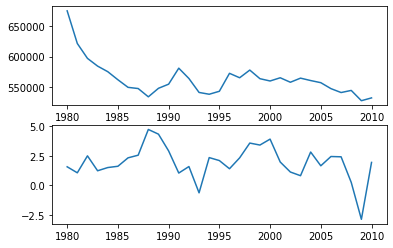

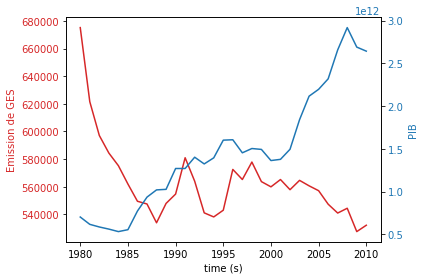

In [106]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

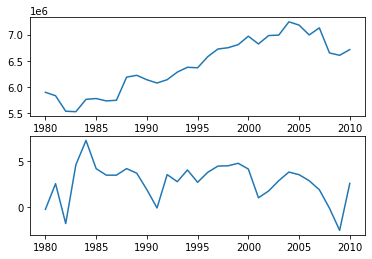

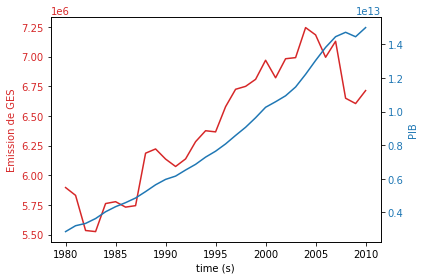

In [107]:
#Sur deux subplots différents
plt.subplot(211)
plt.plot(t[0:31],df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T)
plt.subplot(212)
plt.plot(t[0:31],df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T)

plt.show()

#Sur le même plot\n",

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_Émissions totales de GES (kt d’équivalent CO2)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP (current US$)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Maintenant qu'on à la croissance des émissions de gazs à effet de serre par an, on peut représenter la croissance du PIB et celle-ci sur le même graphe :

KeyError: 'USA_croissance émissions GES (pourcent)'

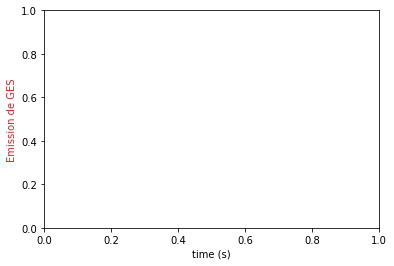

In [164]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['USA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['USA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

KeyError: 'FRA_croissance émissions GES (pourcent)'

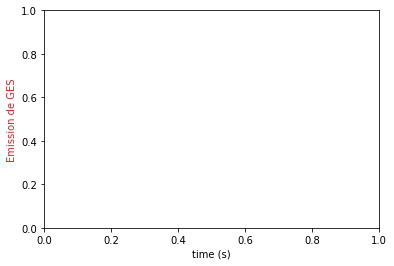

In [165]:
#Sur le même plot,

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Emission de GES', color=color)
ax1.plot(t[0:31], df1.loc['FRA_croissance émissions GES (pourcent)'][2:42].to_numpy()[1:32].T, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  #  commence un deuxième axe qui partage le même axe x

color = 'tab:blue'
ax2.set_ylabel('Croissance du PIB', color=color)  
ax2.plot(t[0:31], df1.loc['FRA_GDP growth (annual %)'][2:42].to_numpy()[1:32].T, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On peut voir qu'il y a apparemment une certaine concommitance des courbes, cela-dit il faut faire attention aux effets d'échelles car ici le PIB ne passe presque jamais dans le négatif (ce qui est loin d'être le cas de la croissance des émissions de gaz à effet de serre). On va essayer de le faire dans le cas de la France pour se faire plus d'idées :

# Suppression des lignes inutiles :

On va chercher à enlever les lignes qui ne contiennent que peu d'infos (au moins 10 valeurs manquantes)

In [108]:
nan_dict = {}
for i in range(len(df1.index)) :
    nb_nan = df1.iloc[i].isnull().sum()
    if nb_nan >10 :
        nan_dict[list(df.index)[i]] = nb_nan


df1 = df1.drop(index = nan_dict.keys(), axis = 0)
df1.shape

(1977, 43)

En faisant cela, on supprime environ 600 lignes.

In [109]:
dic_pays = refresh_dico('Country Name','Country Code',df1)

In [110]:
for i in dic_pays.keys() :
    if len(rech_ligne_pays(i,df1))<7 :
        df1 = df1.drop(rech_ligne_pays(i,df1))
dic_pays = refresh_dico('Country Name','Country Code',df1)
#ancienne fonction que j'ai écrite plus tot (beaucoup plus lente) :

#for i in nom_pays : 
#    compter_nb_indic = df1.apply(lambda x: True if x['Country Name'] == i else False, axis = 1)
#    if len(compter_nb_indic[compter_nb_indic == True].index) <3 :
#        liste_pays_dic[i] = compter_nb_indic[compter_nb_indic == True].index'''


In [111]:
df1.shape

(1974, 43)

On supprime les lignes des pays dont on a trop peu d'indicateurs complet : (servait pourl'ancienne fonction)

In [112]:
#for i in liste_pays_dic.keys():
#    df1 = df1.drop(index = liste_pays_dic[i], axis = 1)

On a supprimer en tout 58 lignes. De plus on va aussi supprimer de la base les aggrégats de pays (ces lignes là sont colinéaires aux autres, ce qui risque de nous poser problème plus tard dans la prédiction). Voilà les régions à supprimer : Upper middle income, Latin America & the Caribbean (IDA & IBRD countries),Middle East & North Africa (IDA & IBRD countries),South Asia (IDA & IBRD), Middle East & North Africa (IDA & IBRD countries), Latin America & the Caribbean (IDA & IBRD countries),East Asia & Pacific (IDA & IBRD countries), Europe & Central Asia (IDA & IBRD countries), Sub-Saharan Africa, Sub-Saharan Africa (excluding high income), Post-demographic dividend, Pre-demographic dividend, OECD members, North America, Middle East & North Africa (excluding high income), Middle East & North Africa,Late-demographic dividend, Lower middle income
Low & middle income,Latin America & Caribbean,Least developed countries: UN classification, Latin America & Caribbean (excluding high income),IBRD only,IDA & IBRD total,IDA total,IDA blend,Heavily indebted poor countries (HIPC),High income, European Union, Fragile and conflict affected situations,East Asia & Pacific (excluding high income)
Early-demographic dividend, East Asia & Pacific, Europe & Central Asia (excluding high income), Europe & Central Asia,Central Europe and the Baltics

In [113]:
#/!\ il ne faut faire tourner qu'une seule fois cette fonction, sinon on a une KeyError


suppr_liste = ['Arab World', 'Le monde arabe', 'Central Europe and the Baltics', 'Europe centrale et les pays baltes',
 'Caribbean small states', 'Petits états des Caraïbes','East Asia & Pacific (excluding high income)', 
 'Asie de l’Est et Pacifique (hors revenu élevé)', 'Early-demographic dividend', 
 'de dividende précoce démographique', 'East Asia & Pacific', 'Asie de l’Est et Pacifique',
 'Europe & Central Asia (excluding high income)', 'Europe et Asie centrale (hors revenu élevé)',
 'Europe & Central Asia', 'Europe et Asie centrale',  'Euro area', 'Zone euro', 
 'European Union', 'Union européenne','Fragile and conflict affected situations',
 'Fragile et les situations de conflit touchées', 'High income',
 'Revenu élevé','Heavily indebted poor countries (HIPC)','Pays pauvres très endettés (PPTE)','IBRD only',
 'BIRD seulement','IDA & IBRD total',
 'BIRD et IDA',
 'IDA total',
 'IDA totale',
 'IDA blend',
 'IDA mélange','IDA only',
 'IDA seulement','Latin America & Caribbean (excluding high income)',
 'Amérique latine et Caraïbes (hors revenu élevé)','Latin America & Caribbean',
 'Amérique latine et Caraïbes',
 'Least developed countries: UN classification',
 'Pays les moins avancés\xa0: classement de l’ONU',
 'Low income',
 'Faible revenu','Lower middle income',
 'Revenu intermédiaire, tranche inférieure',
 'Low & middle income',
 'Revenu faible et intermédiaire','Late-demographic dividend',
 'de dividende tardif démographique','Middle East & North Africa',
 'Afrique du Nord et Moyen-Orient','Middle income',
 'Revenu intermédiaire', 'Middle East & North Africa (excluding high income)',
 'Afrique du Nord et Moyen-Orient (hors revenu élevé)','North America',
 'Amérique du Nord','OECD members',
 "Pays membres de l'OCDE",'Other small states',
 'Autres petits états','Pre-demographic dividend',
 'de Pré-dividende démographique', 'Pacific island small states',
 'Petits états insulaires du Pacifique',
 'Post-demographic dividend',
 'de Post-dividende démographique','South Asia',
 'Asie du Sud','Sub-Saharan Africa (excluding high income)',
 'Afrique subsaharienne (hors revenu élevé)',
 'Sub-Saharan Africa',
 'Afrique subsaharienne',
 'Small states',
 'Petits états','East Asia & Pacific (IDA & IBRD countries)',
 'Asie de l’Est et Pacifique (BIRD et IDA)',
 'Europe & Central Asia (IDA & IBRD countries)',
 'Europe et Asie centrale (BIRD et IDA)','Latin America & the Caribbean (IDA & IBRD countries)',
 'Amérique latine et Caraïbes (BIRD et IDA)',
 'Middle East & North Africa (IDA & IBRD countries)',
 'Afrique du Nord et Moyen-Orient (BIRD et IDA)', 'South Asia (IDA & IBRD)',
 'Asie du Sud (BIRD et IDA)',
 'Sub-Saharan Africa (IDA & IBRD countries)',
 'Afrique subsaharienne (BIRD et IDA)','Upper middle income',
 'Revenu intermédiaire, tranche supérieure','World',
 'Monde']

In [114]:
for i in suppr_liste :
    df1 = df1.drop(labels = rech_ligne_pays(i,df1)) 
dic_pays = refresh_dico('Country Name','Country Code',df1)
df1.shape

KeyError: 'Arab World'

In [115]:
data_csv=df1.to_csv('Complete_Data.csv',index=True)

On a supprimer en tout une centaine de lignes encore.

Idée : on pourrait essayer de faire du clustering afin de déterminer la dépendance de la croissance à certains facteurs afin d'essayer de prédire la dépendance de la croissance à l'émission de gaz à effet de serre.


## Création de la base de données pour le Clustering :

Afin d'étudier les sentiers de croissance et leurs dépendances énergétiques, nous avons retenu trois catégories de variables :

    - La valeur en 2000, qui nous permet d'estimer de manière absolue la niveau des variables. L'année 2000 a été retenu car nous notre base manque de donnée au début des années 80 et après 2010 pour certains pays.
    
    -Le taux de variation moyen, qui nous donne une bonne estimation de l'évolution de la variable sur notre jeu de donnée.
    
    -le coefficient de la régression ainsi que son R² pour les variables qui nous ont parues pertinentes. On a décidé de prendre ces indicateurs pour mesurer la dépendance entre les variables et la significativité de cette dépendance.

On va chercher à créer la base avec les données qui nous intéressent pour la modélisation. Pour ça on définit les fonctions suivantes :


In [116]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            coef = results.params[1]

            return coef, r2
    
    else : return

On automatise aussi la récupération des coefficients sous forme de dictionnaire afin de pouvoir les inclure dans le dataframe.

In [117]:
def get_coeff (regresse, regresseur) :    
    dico = {}
    for code in code_list:
        dico[code] = regress(code,regresseur,regresse )
        if dico[code] == None:
            dico.pop(code)

    regress_df = pd.DataFrame(dico.values(), dico.keys(), ['Coefficient de ' + regresse + ' sur ' + regresseur,
                                                         'R2 de ' + regresse + ' sur ' + regresseur])
    return regress_df


On va aussi récupérer le taux de croissance moyen des économies sur la période :

In [118]:
def get_average_growth_rate(var) :
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :    
            values = list(df1.loc[country_code + var][3:])
            values = [x for x in values if ~np.isnan(x)]
            initial_value = values[0]
            final_value = values[len(values)-1]
            variation_rate = (100 * ((final_value / initial_value))**(1/(len(values)-1))) - 100
            if variation_rate != np.inf :
                dic[country_code] = variation_rate
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['Average Growth Rate' + var])
    
    return(temp_df)

On récupère les valeurs en 2000 :

In [145]:
def get_2000(var):
    dic = {}
    
    for country_code in code_list : 
        if country_code + var in df1.index :
            dic[country_code] = df1.loc[country_code + var][23]
    
    temp_df = pd.DataFrame(dic.values(), dic.keys(), ['2000' + var])
    
    return(temp_df)

Enfin on créé la base de données avec tous les indicateurs :

In [146]:
data = get_average_growth_rate(dic['pib_hab'])

data_list = [get_average_growth_rate(dic['agr']), get_average_growth_rate(dic['industry']), 
            get_average_growth_rate(dic['ges_hab']), get_average_growth_rate(dic['clean_nrj']),
            get_average_growth_rate(dic['nrj_hab']), 
            get_2000(dic['pib_hab']), get_2000(dic['agr']), get_2000(dic['industry']),
            get_2000(dic['ges_hab']), get_2000(dic['clean_nrj']), get_2000(dic['nrj_hab']), 
            get_coeff(dic['pib_hab'], dic['ges_hab']),
            get_coeff(dic['pib_hab'], dic['nrj_hab'])]
for i in data_list :
    data = data.merge(i, how = 'outer', left_index = True, right_index = True)

KeyError: 'pib_hab'

Après plusieurs essais, nous avons automatisé l'application de la méthode des K-means à un dataframe ne contenant pas de NaN.

Cette fonction normalise la base, applique la méthode des K-means, puis réalise une ACP sur la base afin d'obtenir une représentation en deux dimensions.
Elle peut optionnellement tracer le graphe de l'inertie du clustering en fonction du nombre de cluster, elle peut également représenter la part de la variance expliquée pour chaque vecteur propre de l'ACP.

In [121]:
def get_cluster_ACP(n_k_means, data, graph_ACP=False,to_normalize=True,graph_k_means=False,seed=False):
    #normalisation
    if to_normalize == True :
        data_norm = pd.DataFrame()
        for i in data.columns :
            data_norm[i] = preprocessing.scale(data[i])
            data_norm.index = data.index
    else : 
        data_norm=data
        
    #On crée le graphe du coude des clusters
    if graph_k_means==True:
        iner = []
        for k in range(2,10):
            result=data_norm.copy()
            centroid, appartenance, inertie = sklearn.cluster.k_means(data_norm, k)
            iner.append(inertie)
        plt.plot(np.linspace(2,9,num=8),iner)
        plt.title("Evolution de l'inertie en fonction du nombre de cluster")
        plt.show() 
    
    
    #graph ACP
    if graph_ACP==True:
        
        PCA = sklearn.decomposition.PCA(10)
        PCA.fit(data_norm)

        res = PCA.explained_variance_ratio_

        t=np.linspace(1,10,num=10)
        plt.plot(t,PCA.explained_variance_ratio_*100)
        plt.title("Part de la variance expliquée sur chaque axe de l'ACP")
        plt.show()

    #on enregistre dans la base les centroïdes
    result=data_norm.copy()
    if seed != False:
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means,random_state=seed)
    else :
        centroid, result['Cluster'], inertie = sklearn.cluster.k_means(data_norm, n_k_means)
    for i in range(0,n_k_means):
        result.loc['Centroid '+str(i)] = np.concatenate((centroid[i],np.array([i])))
    
     
        
    #Application de l'ACP
    PCA = sklearn.decomposition.PCA(2)
    PCA.fit(data_norm)
    data_ds_acp = PCA.transform(data_norm)
    result_ACP = pd.DataFrame(data_ds_acp)
    
    #Enregistrement des données de l'ACP
    data_norm.loc['axis_1']=PCA.components_[0]
    data_norm.loc['axis_2']=PCA.components_[1]
    PCA_axis=data_norm.loc[['axis_1','axis_2']]
    
    #représentation graphique des clusters dans l'ACP
    result_ACP.index = result.index[:-n_k_means]
    result_ACP['Cluster'] = result['Cluster'][:-n_k_means]
    
    f = go.FigureWidget([go.Scatter(x=list(result_ACP[0]), 
                                y=list(result_ACP[1]), 
                                text=result_ACP.index,
                                mode='markers',
                                hoverinfo='text'
                                )])

    scatter = f.data[0]
    colormap = np.array(['black','red','royalblue','forestgreen','gold','silver','darkgoldenrod','deeppink','mediumturquoise','orange','firebrick'])

    
    
    scatter.marker.color = colormap[result_ACP['Cluster'].astype(int).to_numpy()]
    scatter.marker.size = [10] * len(result_ACP.index)
    f.layout.hovermode = 'closest'
    
    #plt.title("Représentation des clusters dans L'ACP")
    f.show()
    
    dic_cluster={}
    for i in range (n_k_means):
        dic_cluster['Cluster'+str(i)]=list(result.where(result['Cluster'] == i).dropna().index[:-1])
        dic_cluster['Cluster'+str(i)].append(colormap[i])

        
    return result,dic_cluster,PCA_axis

A notre première tentative, nous avons appliqué cette méthode sur notre base où avons supprimé tous les pays dont il manquait un indicateur

In [122]:
data_1=data.dropna(axis=0)

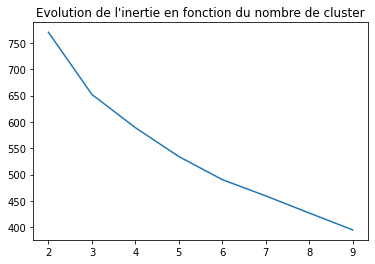

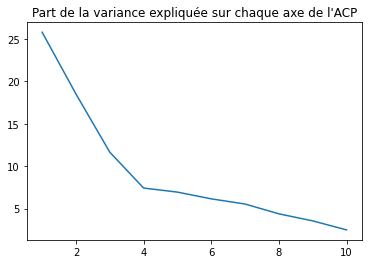

In [123]:
A,dic,axis=get_cluster_ACP(3,data_1,graph_ACP=True,graph_k_means=True,seed=1)

Dans un souci de visualisation, nous avons choisi de nous limiter au deux premiers axes de l'ACP, qui expliquent environ 45 % de la variance de notre jeu de donnée. On peut afficher axis pour les interpréter :

In [124]:
axis

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)
axis_1,-0.083922,-0.113444,-0.242245,-0.180743,0.068738,-0.233689,0.432991,-0.310303,-0.036326,0.226164,0.372706,0.418256,-0.315826,0.005593,0.011666,-0.281782
axis_2,0.417687,-0.243149,-0.188613,0.329397,0.033347,0.410420,0.111488,-0.292115,0.183203,0.008673,0.069575,0.163092,0.077947,0.370132,0.193883,0.330574


Les pays à droite dans ce plan sont, grossièrement, les pays avec dont les indicateurs économiques sont significativement au-dessus de la moyenne en 2000, et dont le rythme de croissance de nos indicateurs est plutôt inférieur à la moyenne. Les pays plutôt en haut, quand à eux, sont ceux dont la croissance a été très au-dessus de la moyenne, ce qui passe par une forte consommation d'énergie. Certte dernière est pour eux assez corrélée avec l'augmentation de la production, d'après les coefficients de régression et les R² associés.

In [125]:
A.tail(3)

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,-0.149869,-0.287462,-0.779616,-0.510795,0.412393,-0.718084,1.721108,-0.883848,-0.371547,0.900930,1.369394,1.774649,-1.322678,0.161678,-0.041373,-0.971783,0.0
Centroid 1,0.662221,-0.369528,-0.068925,0.732833,-0.149695,0.893346,-0.302165,-0.140460,0.091702,-0.338126,-0.220337,-0.303177,0.483463,0.831323,0.209392,0.866244,1.0
Centroid 2,-0.478530,0.418211,0.373782,-0.389021,-0.046038,-0.435359,-0.454984,0.474536,0.076651,-0.091535,-0.378367,-0.475972,0.144936,-0.743243,-0.153760,-0.309917,2.0


Après de multiples essais, nous en sommes arrivés à la conclusion que les meilleurs clusters stables sont ceux ci-dessus. En effet, nous avons remarqué que lorsque le nombre de cluster augmentait, les clusters étaient plus précis mais ne se retrouvaient pas nécessairement d'une fois sur l'autre. Nous avons donc choisi de nous concentrer sur les clusters suffisamment reconnaissables par l'algorythme pour rester stable, gage de significativité du cluster.

On retrouve très clairement trois catégories de pays :

-Les pays de l'OCDE, en rouge, associé au Centroïde 1, caractérisés par une croissance du PIB faible, une tendance à la baisse des secteurs industriels et agricoles, une taux de variation de la production énergétique étonnamment bas, et des valeurs en 2000 plus importantes que la moyenne, et une décorrélation du PIB aux émissions de GES et à la production énergétique.

-Les pays les moins développés, en bleu, associé au Centroïde 2, qui ont pour caractéristiques communes des indicateurs de faible valeur en ce qui concerne le PIB, l'énergie, l'émission de GES, la part d'énergie renouvelable et nucléaire, et une part importante de l'agriculture et de l'industrie dans le PIB. On retrouve également pour ces pays-là une faible corrélation du PIB à la croissance énergétique et aux émission de GES.

-Les pays en cours de développement, en noir, associé au Centroïde 0. Ces derniers se distinguent par une forte croissance du PIB, des émissions de GES et du secteur énergétique, bien que leurs valeurs nominales soient inférieures à celles de l'OCDE. Pour ce cluster, le PIB est corrélé de manière significative au émissions de GES et à la croissance énergétique.

### Suppression de certains indicateurs pour augmenter le jeu de donnée, et clustering sur cette nouvelle base

 Dans le but de rendre notre modèle plus pertinent par le biais d'un échantillon plus représentatif, nous avons choisi de faire entrer de nouveaux pays en éliminant certains indicateurs pour lesquels nous avions essentiellement des données sur les pays riches.

In [126]:
data_2=data.drop(['Average Growth Rate_Alternative and nuclear energy (% of total energy use)','Average Growth Rate_Energy use (kg of oil equivalent per capita)',
                '2000_Energy use (kg of oil equivalent per capita)','2000_Alternative and nuclear energy (% of total energy use)',
                'Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)',
                'R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita)'],axis=1)

In [127]:
data_2=data_2.dropna(axis=0)
data_2.shape

(108, 10)

Grâce à cette modification de la conception de notre base, nous l'avons étendu à 108 pays, ce qui est plus pertinent pour faire du clustering. C'est ce que nous faisons maintenant

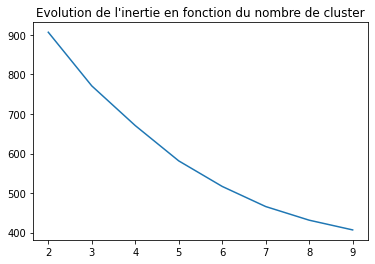

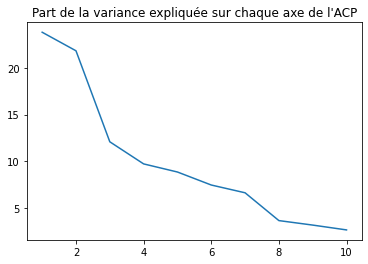

In [128]:
A,dic,axis=get_cluster_ACP(2,data_2,graph_ACP=True,graph_k_means=True)

Cette fois-ci, on voit clairement un "coude" dans le graphe de l'ACP, et on voit que les deux premiers axes permettent de rerésenter près de 50% de la variance totale, ce qui nous indique que notre représentation graphique est de qualité très correcte. En revanche, il est toujours aussi difficile de déterminer un nombre de cluster pertinent en se fondant sur l'inertie intraclasse. Comme l'analyse des axes n'apporte pas grand chose de plus que celle des clusters, nous ne l'effectuons plus à partir de maintenant.

In [129]:
A,dic,axis=get_cluster_ACP(5,data_2, seed = 2)

In [130]:
A.tail()

,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_GDP (current US$) par Tete,"2000_Agriculture, forestry, and fishing, value added (% of GDP)","2000_Industry (including construction), value added (% of GDP)",2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Cluster
Centroid 0,-0.228290,-0.100091,-0.609938,-0.539032,2.282571,-1.102016,0.128125,1.230458,-0.394336,0.294405,0.0
Centroid 1,-0.655819,0.838425,-0.052430,-0.165662,-0.508333,0.993746,-0.622814,-0.241299,-0.072349,-0.464800,1.0
Centroid 2,0.091135,-0.400299,0.290469,-0.222065,-0.359641,-0.180779,0.407021,-0.072700,-0.081847,-0.554439,2.0
Centroid 3,1.031370,-0.488027,-0.052222,1.097042,-0.230253,-0.398870,0.054877,-0.342128,0.081484,1.588115,3.0
Centroid 4,0.884699,-0.794461,0.595429,0.272024,1.167447,-1.235619,1.659612,-0.816174,9.864895,0.783132,4.0


Si l'on garde 5 clusters, on arrive à identifier un motif qui se répète assez souvent. Il s'agit de celui inidqué ci-dessus, avec une seed égale à 5. 

    -Le cluster 0, en noir, correspond aux pays qui se sont beaucoup développé sur la période, notamment à l'aide d'un accroissement de l'émission de GES assez marque, leur PIB y étant significativement dépendant.
    -Le cluster un correspond à des pays de niveau de développement intermédiaire, dont la croissance de l'ensemble des indicateurs était inféreure à la moyenne. Il s'agit de pays dont le secteur agricole, contrairement au secteur industriel, était assez peu développé en 2000.
    -Le centroïde deux ne concerne que Puerto Rico, qui est une valeur assez singulière dans cette base. Il s'agit d'une valeur isolée, et sans l'isoler dans un cluster on rend le reste du modèle instable en déplaçant l'un des centroïdes vers un point non pertinent. Ainsi, si l'on ne garde que quatre clusters, leur structure est très instable. Puertor Rico a notamment une valeur presque aberrante en ce qui concerne le coefficient de régression du PIB sur l'émission de GES.
    -Le cluster 3 regroupe les pays qui polluaient beaucoup en 2000, et qui avaient un PIB très supérieur à la moyenne. Avec une croissance faible de l'industrie et un secteur industriel peu important et stagnant, il s'agit peu ou prou des pays industriels développés occidentaux.
    - Le dernier cluster regroupe des pays peu développés : ils sont fortement agricole, leur croissance est faible, et leur agriculture (et dans une moindre mesure leur industrie) représentent une part plus importante de leur PIB que dans les autres pays. 
    
Cette analyse à cinq clusters reste assez peu stable, mais elle permet de raffiner un peu l'analyse contrairement aux analyses avec moins de clusters. Celle en deux cluster oppose les pays développés (caricaturalement les pays occidentaux) aux pays en cours de développement. Et celle à trois clusters conserve un cluster pays développé (très stable quelque soit le nombre de clusters) et divise le cluster des pays moins développés entre ceux qui ont eu une forte croissance et ceux qui restent encore peu avanccés. On met les graphiques ci-dessous :

### On refait une analyse enconservant les variables sur l'énergie, mais en supprimant celles sur les secteurs d'activité

On a réussi à obtenir des résultats sur un échantillon plus grand, mais en supprimant certaines variables qui nous intéressaient, puisqu'eles portaient sur l'énergie. On cherche à voir si on peut retrouver ces résultats en conservant ces données, mais en supprimant celles portant sur les secteurs d'activité afin d'avoir un échantilllon plus important.

In [131]:
data_set_3=data.drop(['Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)',
                  'Average Growth Rate_Industry (including construction), value added (% of GDP)',
                  '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                  '2000_Industry (including construction), value added (% of GDP)'],axis=1)
data_set_3=data_set_3.dropna()
data_set_3.shape

(82, 12)

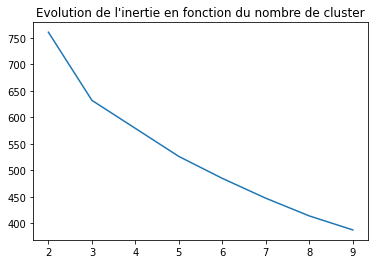

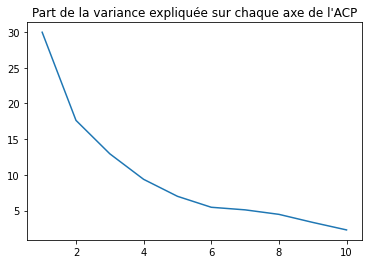

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,-0.027435,0.160944,-0.152678,0.198076,-0.426557,-0.291768,-0.340112,-0.459276,0.343863,-0.055951,0.109952,0.251935,0.0
Centroid 1,0.085049,-0.498926,0.473303,-0.614035,1.322327,0.904479,1.054348,1.423755,-1.065977,0.173447,-0.340851,-0.780998,1.0


In [132]:
A,dic,axis=get_cluster_ACP(2,data_set_3,graph_k_means=True,graph_ACP=True)
A.tail(2)

En ce qui concerne l'ACP, notre premier axe permet d'expliquer une grande part de la variance, et le deuxième apporte une contribution honorable. Notre représentation graphique devrait donc avoir du sens.
En revanche, il est toujours difficile de trouver un bon nombre de clusters en se basant sur l'inertie intraclasse.

On retrouve deux clusters la séparation entre pays riches et polluants d'une part, et les pays en cours de développement d'auttre part. Un des facteurs de séparation est toutefois l'élasticité énergétique du PIB. On voit ici que le centroïde correspondant au cluster des pays développés à des coefficients assez négatifs en ce qui concerne les coefficients des régressions, ainsi que le R² de la seconde régression. On voit donc que la production des pays développés est moins corrélée que celle des autres pays aux énergies utilisées, ainsi qu'à la quantité de GES émise. On pourrait expiquer cela par un niveau de développement plus avancé et donc à la fois une économie déjà assez industrialisée et surtout une part d'énergie alternative significativement au-dessus de la moyenne.

Ce dernier résultat est donc assez solide, puisqu'on le retrouve avec toutes nos bases jusqu'à présent. On va chercher à voir, avec plus de clusters, s'il est possible de raffiner cette analyse au niveau des pays en développement.

In [133]:
A,dic,axis=get_cluster_ACP(4,data_set_3, seed = 2)
A.tail()

,Average Growth Rate_GDP (current US$) par Tete,Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),2000_GDP (current US$) par Tete,2000_Émissions totales de GES (kt d’équivalent CO2) par Tete,2000_Alternative and nuclear energy (% of total energy use),2000_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
ZMB,-1.333725,-0.500974,-0.890624,-1.101673,-0.725765,2.215465,0.008550,-0.666205,0.110394,-1.252929,-0.719448,-1.481824,3.0
Centroid 0,-0.073701,-0.392816,-0.098601,-0.299003,1.518215,1.120080,1.341135,1.707118,-1.273553,0.060448,0.460456,-0.643471,0.0
Centroid 1,0.366070,0.708603,-0.132416,0.800043,-0.326233,-0.394083,-0.309147,-0.381859,0.546839,0.561470,0.239406,0.853309,1.0
Centroid 2,0.733658,-0.702401,1.352924,-1.324722,0.505113,0.255611,0.380339,0.550171,-0.475242,-0.036956,-1.441138,-1.181592,2.0
Centroid 3,-0.752995,-0.478475,-0.309812,-0.402687,-0.547840,-0.148734,-0.429086,-0.588442,0.108643,-0.780250,0.011426,-0.353258,3.0


Avec trois clusters, on a tendance à retrouver la même partition que dans notre modèle précédent.Les pays développés restent dans un même cluster. Les pays qui ont eu un rattrappage dans le développement qui est passé par une forte utilisation d'énergie et une forte émission de GES forment un second cluster, et les pays dont le développement est moins marqué forment un troisième cluster.

En revanche, la structure à qutre cluster que l'on retrouve avec la seed 2 est assez récurrente, et permet de faire une distinction supplémentaire parmi les pays développés au prix d'une plus forte instabilité de la séparation entre les deux clusters des pays en développement. 

Le cluster 2 est un cluster où les pays ont une évolution moins importante de l'utilisation de l'énergie que les autres pays développés. L'évolution de leurs émissions est en moyenne inférieur aussi, et au contraire il s'agit de pays qui ont beaucoup développé leur utilisation d'énergies alternatives sur la période même si en 2000 elle restait plus faible. Si l'on regarde les coefficients de nos régressions, il s'git de pays dont la production est beaucoup moins dépendante de la consommation d'énergie que les autres. C'est la premùière fois que l'on arrive à obtenir ces résultats, mais ils ne ssont pas totalement stable. De plus, on peut s'étonner de retrouver des pays comme l'Allemagne ou les USA dans ce cluster des pays "modèles" en terme d'élasticité énergétique de la croissance.

## On enlève les valeurs en 2000 pour n'avoir que des évolutions.

Pour se concentrer davantage sur ces sentiers de croissance, on décide de ne plus conserver les valeurs de nos variables en 2000. On espère voir davantage les clusters se concentrer sur les évolutions, et peut-être ne plus voir systématiquement apparaitre un cluster de pays riches. En revanche, comme on conserve tous nos indicateurs pour ce faire, on se retrouve sur une base avec seulement les 60 pays initiaux.

In [155]:
data_set_4=data.drop(['2000_GDP (current US$) par Tete',
                      '2000_Émissions totales de GES (kt d’équivalent CO2) par Tete',
                      '2000_Agriculture, forestry, and fishing, value added (% of GDP)',
                      '2000_Industry (including construction), value added (% of GDP)',
                      '2000_Alternative and nuclear energy (% of total energy use)',
                      '2000_Energy use (kg of oil equivalent per capita)'],axis=1)
data_set_4=data_set_4.dropna()
data_set_4.shape

(60, 10)

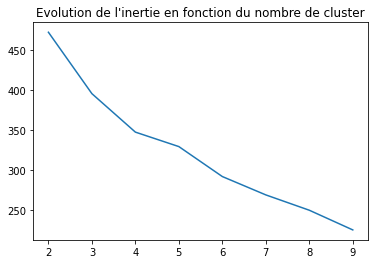

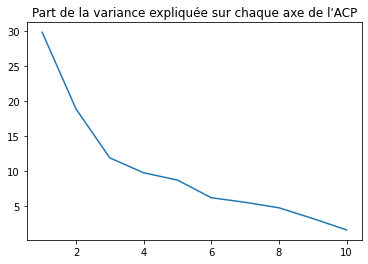

{'Cluster0': ['ARG', 'AUS', 'BGR', 'CHE', 'CIV', 'CMR', 'COG', 'COL', 'CUB', 'DNK', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GHA', 'HND', 'HTI', 'IDN', 'ITA', 'KEN', 'MEX', 'NGA', 'NLD', 'NOR', 'NZL', 'PHL', 'PRY', 'ROU', 'SDN', 'SWE', 'TGO', 'VEN', 'ZMB', 'black'], 'Cluster1': ['AUT', 'BGD', 'BOL', 'BRA', 'BWA', 'CHL', 'CHN', 'CRI', 'DOM', 'ECU', 'EGY', 'GTM', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'NPL', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'URY', 'VNM', 'red']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,-0.421144,0.198043,0.010736,-0.512671,0.028307,-0.604896,-0.344178,-0.452141,-0.141048,-0.664369,0.0
Centroid 1,0.550727,-0.258979,-0.014039,0.670416,-0.037016,0.791018,0.450079,0.591261,0.184447,0.868790,1.0


In [135]:
A,dic,axis=get_cluster_ACP(2,data_set_4,graph_ACP=True,graph_k_means=True)
print(dic)
A.loc[['Centroid 0', 'Centroid 1']]

La représentation dans le plan de l'ACP semble une nouvelle fois relativement fiable au vu de la varaince expliquée par les deux premiers axes (surtout par le premier). 

Il est toujours aussi difficile en revanche de trouver un nombre de cluster optimal par cette méthode de l'inertie intraclasse.

Cette fois-ci, lorsque l'on partitionne nos données en deux clusters, la distinction ne se fait plus selon le niveau des variables en 2000. Il s'agit au contraire de séparer d'un côté les pays qui ont eu une forte croissance, basée sur l'augmentation de l'utilisation de l'énergie par tête et des émission de GES. On retrouve ainsi des coefficients relativement importants et significatifs en ce qui concerne la régression linéaire du PIB sur ces dex indicateurs. En revanche, leur industrie et leur développement des énergies alternatives ne sont que proches de la moyenne, et le développement de l'agriculture un peu en-dessous. Le second cluster représente alors les pays qui ont une trajectoire exactement inverse.

On regarde si on peut raffiner un peu plus.

In [136]:
A,dic,axis=get_cluster_ACP(3,data_set_4, seed = 1)
print(dic)
A.tail(3)

{'Cluster0': ['AUT', 'BGD', 'BWA', 'CHL', 'CHN', 'CRI', 'DOM', 'EGY', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'VNM', 'black'], 'Cluster1': ['BGR', 'CHE', 'COL', 'CUB', 'DNK', 'FRA', 'GBR', 'GHA', 'NLD', 'PHL', 'PRY', 'ROU', 'SWE', 'ZMB', 'red'], 'Cluster2': ['ARG', 'AUS', 'BOL', 'BRA', 'CIV', 'CMR', 'COG', 'ECU', 'ETH', 'FIN', 'GAB', 'GTM', 'HND', 'HTI', 'IDN', 'ITA', 'KEN', 'MEX', 'NGA', 'NOR', 'NPL', 'NZL', 'SDN', 'TGO', 'URY', 'VEN', 'royalblue']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,0.732433,-0.413504,0.040522,0.795579,-0.139363,0.957838,0.493163,0.975196,0.133600,0.841041,0.0
Centroid 1,-0.122751,-0.635759,-0.257467,-0.597851,0.360436,-1.036363,-0.841318,0.029552,-0.838114,-1.506840,1.0
Centroid 2,-0.497313,0.660412,0.107466,-0.290064,-0.086879,-0.178756,0.073661,-0.766063,0.348523,0.164421,2.0


La structure à trois clusters est relativement stable aussi, on identifie trois groupes de pays relativement satbles, avec seulement quatre ou cinq pays qui changent de groupes d'une fois sur l'autre. Ici, avec la graine 1, cela donne :

Le cluster 0 comprend les pays qui ont une corissance économique relativement lente, avec notamment une agriculture peu dynamique. Il s'agit surtout d'un groupe de pays où 'utilisation d'énergie, et dans une moindre mesure les émissions de GES, croit moins vite que dans les autres pays. On y voit que le PIB ne dépend que très peu de l'utilisation d'énergie ou de la production de GES. Il s'agit donc de pays ayant pour la plupart atteit un niveau de développement assez élevé (ou pour les autres qui stagnent, comme le Ghana), et qui semblent plafonner. Toutefois, cela se traduit par une plus faible émission de GES, ce qui est une bonne nouvelle. Certains points restent bien isolés quand on augmente le nombre de clusters (notamment la Suède, la Suisse, la Grande Bretagne, le Danemark, la Roumanie, la Bulgarie et la Colombie).

Le cluster 1 est assez semblable au cluster des pays au développement économique fort et polluant que l'on retrouvait à deux clusters. On y retrouve des pays qui correspondent bien à cette définition, comme la Chine, la Corée, la Turquie ou l'Autriche. 

Le cluster 2 regroupe des pays au développement plus incertain. La croissance économique est inférieure à la moyenne, et la seule évolution significativement au-dessus de la moyenne est celle de l'agriculture. Il s'agit en fait d'un cluster très dur à interpréter, qui est souvent divisé en deux ou trois lorsque le nombre de clusters augmente. On y retrouve des pays ausssi différent apparemment que la Nouvelle Zélande, l'Italie, l'Éthiopie et l'Uruguay. 


In [137]:
A,dic,axis=get_cluster_ACP(4,data_set_4, seed = 2)
print(dic)
A.tail(4)

{'Cluster0': ['AUT', 'BGD', 'BWA', 'CHL', 'CHN', 'CRI', 'DOM', 'EGY', 'IND', 'KOR', 'LKA', 'MAR', 'MYS', 'PAK', 'PAN', 'SLV', 'THA', 'TUN', 'TUR', 'VNM', 'black'], 'Cluster1': ['CIV', 'CMR', 'COG', 'CUB', 'ETH', 'GHA', 'HND', 'HTI', 'PHL', 'PRY', 'SDN', 'ZMB', 'red'], 'Cluster2': ['BGR', 'CHE', 'COL', 'DNK', 'FRA', 'GBR', 'NLD', 'ROU', 'SWE', 'royalblue'], 'Cluster3': ['ARG', 'AUS', 'BOL', 'BRA', 'ECU', 'FIN', 'GAB', 'GTM', 'IDN', 'ITA', 'KEN', 'MEX', 'NGA', 'NOR', 'NPL', 'NZL', 'TGO', 'URY', 'VEN', 'forestgreen']}


,Average Growth Rate_GDP (current US$) par Tete,"Average Growth Rate_Agriculture, forestry, and fishing, value added (% of GDP)","Average Growth Rate_Industry (including construction), value added (% of GDP)",Average Growth Rate_Émissions totales de GES (kt d’équivalent CO2) par Tete,Average Growth Rate_Alternative and nuclear energy (% of total energy use),Average Growth Rate_Energy use (kg of oil equivalent per capita),Coefficient de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,R2 de _GDP (current US$) par Tete sur _Émissions totales de GES (kt d’équivalent CO2) par Tete,Coefficient de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),R2 de _GDP (current US$) par Tete sur _Energy use (kg of oil equivalent per capita),Cluster
Centroid 0,0.732433,-0.413504,0.040522,0.795579,-0.139363,0.957838,0.493163,0.975196,0.133600,0.841041,0.0
Centroid 1,-0.790770,0.072258,1.243762,-0.657308,-0.390474,-0.712542,0.114149,-0.765289,-0.605985,-0.696222,1.0
Centroid 2,-0.050505,-0.657978,-0.881307,-0.753915,0.790005,-1.075856,-1.375784,0.490566,-0.863804,-1.499010,2.0
Centroid 3,-0.247625,0.701304,-0.410727,-0.065192,0.019100,-0.048607,0.060474,-0.775555,0.651267,0.264469,3.0


A quatre clusters, le cluster hétérogène identifié ci-dessus est séparé en deux. D'un côté les pays qui ont une croissance significativement plus faible et ue part de l'industrie qui est vraiment plus dynamique, ainqi qu'une croissance qui dépen très peu de la consommation d'énergie. Il s'agit essentiellement des pays les moins développés de notre base de données. De l'autre côté les pays un peu plus développés, dont la part de l'agriculture est assez robuste dans le temps et dont l'évolution de l'industrie est plus faible. 

Ces derniers résultats n'apparaissent toutefois pas de manière automatique, sans doute en raison d'un problème de taille de notre base, qui est trop petite. 

C'est pourquoi nous allons essayer un autre modèle, avec une approche par le clustering hiérarchique, afin de voir s'il est possible de repérer de manière plus évidente des similitudes etre les modèles de développement des pays.
pour cela on définit la fonction suivante qui va nous servir à faire le clustering hiérarchique :

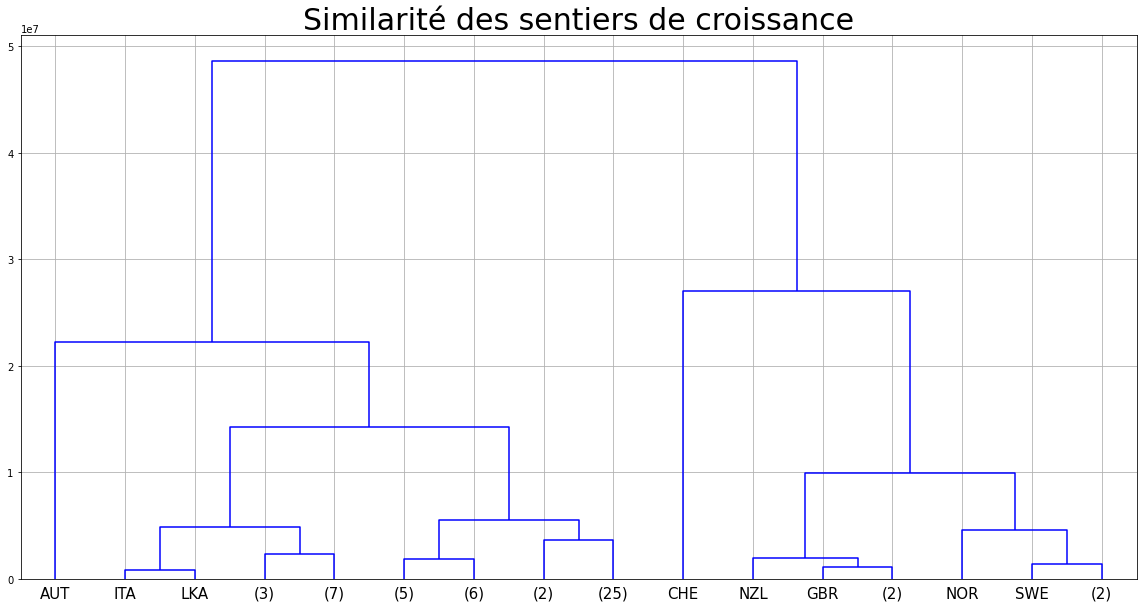

In [158]:
hierarc = linkage(data_set_4,method='ward',metric='euclidean')
fig = plt.subplots(figsize=(20,10))
dendrogram(hierarc,truncate_mode = 'level', p = 4, labels=data_set_4.index, orientation='top', color_threshold=1000, leaf_font_size=15) 
plt.title('Similarité des sentiers de croissance', fontsize=30)
plt.grid()
plt.show()
#cut_tree(Z[, n_clusters, height])

On peut donc voir avec ce clustering hiérarchique que certains pays se démarquent tout particulièrement des autres dans leur sentiers de croissance : en effet on peut voir que l'Australie et la Suisse sont très différents de tous les autres pays du pool puisque ceux ci sont les derniers à être agglomérés aux clusters. 
On eput de plus aussi remarquer la Suède et la Norvège sui se démarque elles aussi en étant

On définit une fonction pour représenter les clusters à différents niveaux d'agglomération sur une carte :

In [164]:
def geo_plot_clas (df,indic,Discrete = False,Titre = None,couleur = 'Oranges',norm=True) : 
    #On importe la map monde dans un data frame avec ses données géographiques : 
    map_monde = gpd.read_file('map_monde (1).json')
    #on créé deux dictionnaires différents pour pouvoir adapter les codes pays et merge le plus correctemment possible
    #les deux dataframe (ici on utilise df1 pour avoir l'équivalence entre Country code et Country name)
    dic_map = refresh_dico('iso_a3','sovereignt',map_monde)
    dic_code = refresh_dico('Country Code','Country Name',df1)  
    liste_non_concord = []
    
    #On récupère tous les pays pour lesquels les codes pays ne correspondent pas :
    for i in dic_map.keys():
        j = ''
        try :
            j = dic_code[i]
        except KeyError:
            liste_non_concord.append(dic_map[i])

    for i in liste_non_concord:
        try :
            map_monde.loc[map_monde['sovereignt'] == i,'iso_a3'] = dic_pays[i]
        except KeyError:
            _
            
    #On peut dés maintenant commencer le plot :
    ax = gplt.polyplot(map_monde['geometry'],
                       edgecolor='None',
                       facecolor='lightgray',
                       figsize=(18, 7))
    if Titre != None :
        ax.set_title(Titre, fontsize = 20)
    
    gdf = create_gdf(df[['Country Code',indic]],map_monde)
    if norm :
        gdf[indic] = log_norm(gdf[indic])
    if Discrete[0] :
        scheme = list(i for i in Discrete[1])
        gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    scheme = scheme,
                    ax=ax)
    else : 
        gplt.choropleth(gdf,
                    hue = indic,
                    cmap = couleur,
                    legend=True,
                    ax=ax)
    plt.show()

In [193]:
liste =list(i for i in range(1,100))
print(cut_tree(hierarc)[-10])
print(rech_lign_pays('Austria',data_set_4))

[50 50 50 50 49 48 47 47 46 45 44 43 42 41 40 40 39 38 37 36 35 34 33 33
 32 31 30 29  9  9  9  8  8  7  7  7  7  7  7  7  7  6  6  6  6  6  6  5
  4  4  4  4  4  4  3  3  0  0  0  0]


NameError: name 'rech_lign_pays' is not defined

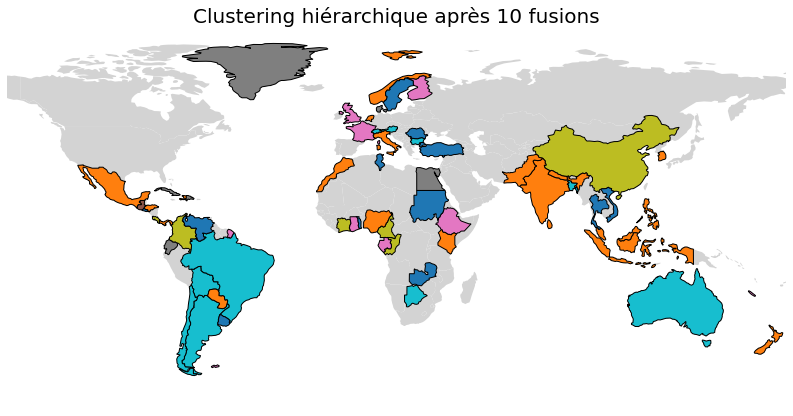

In [172]:
rep_map = data_set_4
rep_map['Country Code'] = rep_map.index
rep_map['Cluster_hierarc_10'] = cut_tree(hierarc)[-10]
geo_plot_clas(rep_map,
              'Cluster_hierarc_10',
              Titre = 'Clustering hiérarchique après 10 fusions',
              couleur = 'tab10',
              Discrete = [True,10],
              norm=False)

On peut voir dans la carte au dessus la représentation du clustering hiérarchique après 10 fusions : 


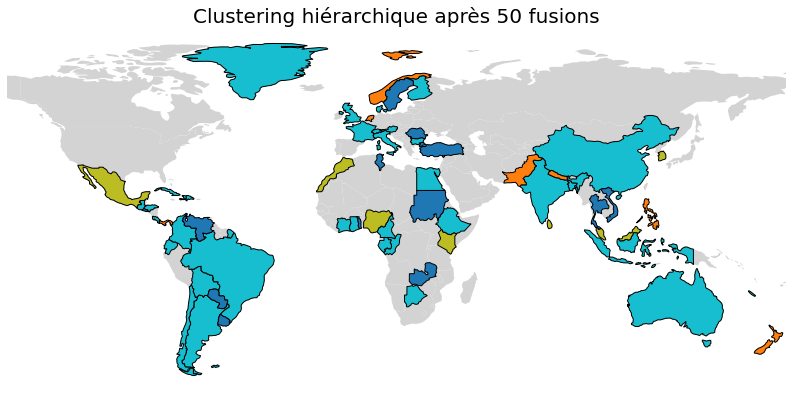

In [177]:
rep_map['Cluster_hierarc_50'] = cut_tree(hierarc)[-50]
geo_plot_clas(rep_map,
              'Cluster_hierarc_50',
              Titre = 'Clustering hiérarchique après 50 fusions',
              couleur = 'tab10',
              Discrete = [True,10],
              norm=False)

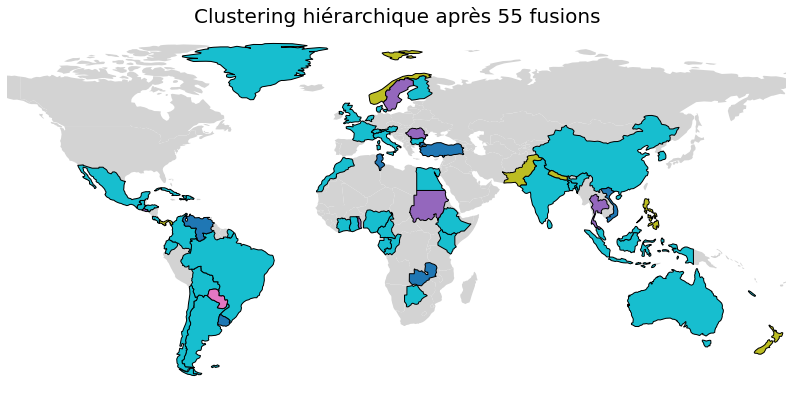

In [181]:
rep_map['Cluster_hierarc_55'] = cut_tree(hierarc)[-55]
geo_plot_clas(rep_map,
              'Cluster_hierarc_55',
              Titre = 'Clustering hiérarchique après 55 fusions',
              couleur = 'tab10',
              Discrete = [True,10],
              norm=False)

### Régressions avec scipy

In [42]:
import scipy.optimize
def affin(x,a,b): 
    return a*x + b

def regress2 (country_code, regresse, regresseur, courbe = False):
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).dropna(axis = 1)
        if interm.shape != (2,0): 

            regresse_val = pd.DataFrame(interm.loc[country_code + regresse][3:30])[country_code + regresse].to_numpy(dtype = float)
            regresseur_val = pd.DataFrame(interm.loc[country_code + regresseur][3:30])[country_code + regresseur].to_numpy(dtype = float)

            popt, pcov = scipy.optimize.curve_fit(affin, regresseur_val, regresse_val)
            coeff, cst = popt[0], popt[1]

            if courbe == True :
                fig, ax1 = plt.subplots()

                color = 'tab:red'
                ax1.set_xlabel('time (s)' + country_code, color = 'k')
                ax1.set_ylabel(regresse, color='k')
                ax1.plot(t[0:31], df1.loc[country_code + regresse][2:42].to_numpy()[1:32].T, color='k')
                ax1.tick_params(axis='y', labelcolor='k')

                ax1.plot(t[0:31], coeff*df1.loc[country_code + regresseur][2:42].to_numpy()[1:32].T + cst, color='b')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                plt.show()

            return coeff, cst
    else : return 
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresseur = '_GDP (current US$)'
regresse = '_Émissions totales de GES (kt d’équivalent CO2)'
dic = {}

for code in code_list:
    dic[code] = regress2(code, regresse, regresseur, False)
    if dic[code] == None:
        dic.pop(code)
#Attention, il faudra donner un nom explicit à chaque df, différent pour chaque régression.
regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Coeff', 'Cst'])
regress2_df.head()

,Coeff,Cst
AGO,-1.708738e-07,42796.716066
ALB,-5.227622e-08,8779.637511
ARE,5.916212e-07,45866.834613
ARG,2.627844e-07,242104.529466
ARM,2.204460e-07,9162.633152


### Régressions graphiques avec Seaborn

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics

C:\Users\SURFACE\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



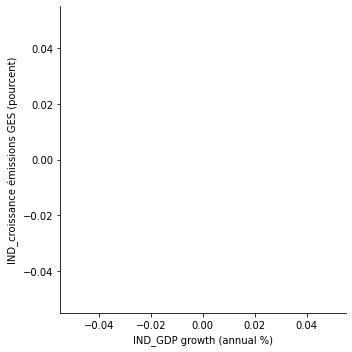

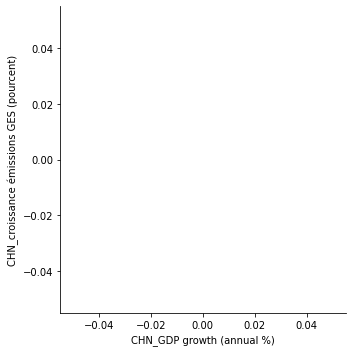

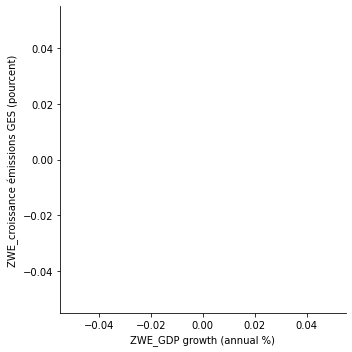

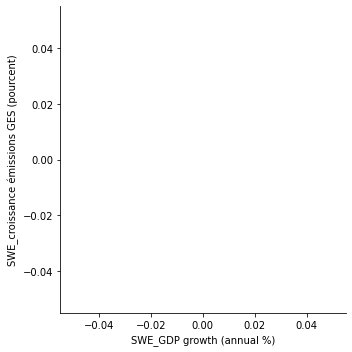

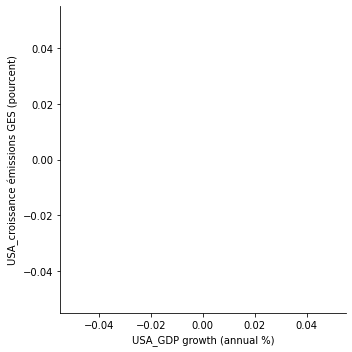

In [44]:

for i in ['IND','CHN','ZWE','SWE','USA']:
    sns.lmplot(x=i+"_GDP growth (annual %)", y=i+"_croissance émissions GES (pourcent)", 
               data=df1.drop(['Country Name','Country Code','Indicator Name'], axis = 1).loc[[i+'_GDP growth (annual %)',i+'_croissance émissions GES (pourcent)']].dropna(axis = 1).T, robust = True)
    
def graph_regress(regresseur,regresse) :
    sns.lmplot(x=regresse, y=regresseur, data=df1.drop(['Country Name',
        'Country Code','Indicator Name'], axis = 1).loc[[regresse,regresseur]].dropna(axis = 1).T, robust = True)

### Régressions avec statsmodels

In [45]:
#On a ici la syntaxe pour faire une régression avec statsmodels, ainsi que la forme de la sortie
x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc['USA_Émissions totales de GES (kt d’équivalent CO2)'].to_numpy())
y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc['USA_GDP (current US$)'].to_numpy()

model = sm.OLS(y,x,'drop')
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     53.28
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           3.25e-08
Time:                        10:52:24   Log-Likelihood:                -988.85
No. Observations:                  33   AIC:                             1982.
Df Residuals:                      31   BIC:                             1985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.343e+13    5.8e+12     -5.762      0.0

In [46]:
interm.head()

NameError: name 'interm' is not defined

In [ ]:
#On voit ici coment récupérer les coefficients voulus
print(dir(results))
results._get_robustcov_results
results.rsquared

On définit ici la fonction qui permet d'automatiser les régressions sur tous les pays, puis on garde les résultats dans un dataframe.

In [ ]:
def regress (country_code, regresseur, regresse) :
    
    if country_code + regresse in df1.index and country_code + regresseur in df1.index :
        interm= pd.DataFrame(df1.loc[[country_code + regresse, country_code + regresseur]]).drop(['Country Name',
        'Country Code','Indicator Name'],axis =1).dropna(axis = 1)

        if interm.shape != (2,0): 
            x = sm.add_constant(interm.loc[country_code + regresseur].to_numpy())
            y = interm.loc[country_code + regresse].to_numpy()

            model = sm.OLS(y,x,'drop')
            results = model.fit()

            r2 = results.rsquared
            cst = results.params[0]
            coef = results.params[1]

            return cst, coef, r2
    
    else : return

    
    
code_list = []
for i in df1['Country Code']:
    if i not in code_list : 
        code_list.append(i)
code_list.pop(-1)

regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'

for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante', 'Coefficient', 'R2'])
regress_df.head()

On peut ensuite effectuer toutes les régressions que l'on souhaite graâce à cette fonction, en changeant simplementles variables regresseur et regresse. Il suffit à chaque fois de créer un dataframe avec un nom différent, de donner des noms plus explicits aux colonnes, et de les concaténer après.

Exemple ci-dessous, en concaténant la régression de gdp sur ges avec celle sur leurs taux de variation

In [ ]:
regresse = '_GDP (current US$)'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'


for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)
        
regress1_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP sur total GES',
                                                     'Coefficient GDP sur total GES', 'R2 GDP sur total GES'])
regress1_df.head()




regresse = 'PIB_test'
regresseur = 'Emission GES test'

dic = {}
for code in code_list:
    dic[code] = regress(code, regresse, regresseur)
    if dic[code] == None:
        dic.pop(code)

regress2_df = pd.DataFrame(dic.values(), dic.keys(), ['Constante GDP_var sur GES_var', 'Coefficient GDP_var sur GES_var', 'R2 GDP_var sur GES_var'])

regress_df = pd.concat([regress1_df, regress2_df], axis = 1)
regress_df.loc['USA']

In [ ]:
regress_df.plot(x='Coefficient GDP sur total GES', y='Coefficient GDP_var sur GES_var', kind = 'scatter', label = "Ce graphique n'est pas extraordinaire")

In [ ]:
for i in code_list :
    df.loc[i+'PIB_test'] = df.loc[i+'_GDP (current US$)'][4:].astype(np.float64)/10
    df.loc[i+'Emission GES test'] = df.loc[i+'_Émissions totales de GES (kt d’équivalent CO2)'][4:].astype(np.float64)/10
#df1.loc[['ARE_Emission de GES par Tete','ARE_Émissions totales de GES (kt d’équivalent CO2)','ARE_Population, total']]   
    

In [ ]:
df.loc[['USAPIB_test','USAEmission GES test']]

In [ ]:

regresse = 'PIB_test'
regresseur = '_Émissions totales de GES (kt d’équivalent CO2)'
x = sm.add_constant(df1.drop(['Country Name','Country Code','Indicator Name'],axis =1).loc['USAEmission GES test'].to_numpy())
y = df1.drop(['Country Name','Country Code','Indicator Name'],axis=1).loc['USAPIB_test'].to_numpy()

model = sm.OLS(y,x,'drop')
results = model.fit()
print(results.summary())
